# Large stretch
[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meyer-nils/torch-fem/blob/main/examples/basic/solid/large_stretch.ipynb)

We compare different material models for uni-axial strain with a large stretch to twenty times its original length.

In [1]:
import matplotlib.pyplot as plt
import torch
from scipy.optimize import fsolve
import numpy as np

from torchfem import Solid
from torchfem.mesh import cube_hexa
from torchfem.materials import IsotropicElasticity3D, Hyperelastic3D


torch.set_default_dtype(torch.float64)

In [2]:
# Material
E = 1000.0
nu = 0.3
lbd = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))
mu = E / (2.0 * (1.0 + nu))
alpha = 2.0


# Generate cube
nodes, elements = cube_hexa(5, 5, 5)

# Boundary sets
left = nodes[:, 0] == 0.0
right = nodes[:, 0] == 1.0
center1 = nodes[:, 1] == 0.5
center2 = nodes[:, 2] == 0.5

# Load
U = 19.0
N = 21
displacements = torch.zeros_like(nodes)
displacements[right, 0] = U
increments = torch.linspace(0.0, 1.0, N)

# Boundary conditions
constraints = torch.zeros_like(nodes, dtype=torch.bool)
constraints[left, 0] = True
constraints[right, 0] = True
constraints[center1, 1] = True
constraints[center2, 2] = True

# Analytical stretch solution
λ = torch.linspace(1.0, 1.0 + U, N)

## Linear elasticity with small strains

In [3]:
# Reference solution
σl_ref = torch.linspace(0.0, E * U, N)

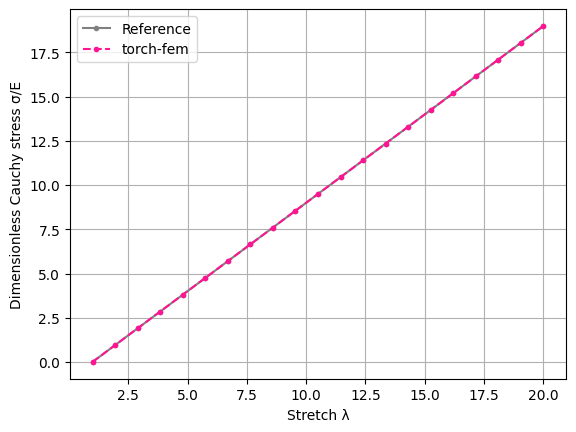

In [4]:
# Create model
material = IsotropicElasticity3D(E=E, nu=nu)
box = Solid(nodes, elements, material)
box.constraints = constraints
box.displacements = displacements

# Solve
_, _, σl, _, _ = box.solve(increments=increments, return_intermediate=True)

# Plot
plt.plot(λ, σl_ref / E, ".-", color="gray", label="Reference")
plt.plot(λ, σl[..., 0, 0].mean(dim=1) / E, ".--", color="deeppink", label="torch-fem")
plt.xlabel("Stretch λ")
plt.ylabel("Dimensionless Cauchy stress σ/E")
plt.grid()
plt.legend()
plt.show()

## Neo-Hookean hyperelasticity 

The strain energy function for this Neo-Hookean material is chosen as 

$$
    \psi(C) = \frac{\mu}{2} \left( \textrm{tr}(C) - 3\right) - \mu \log(J) + \frac{\lambda}{2} \log(J)^2
$$

with the right Cauchy-Green tensor 
$$
    C = F^\top F
$$

and the Jacobian 
$$
    J = \det(F).
$$

In [5]:
# Analytical reference solution
J = fsolve(
    lambda J: mu * (J / λ.numpy() - 1) + lbd * np.log(J),
    x0=np.ones(λ.shape),
    xtol=1e-10,
)

# Convert J to a numpy array (just to make the linters happy)
J = np.asarray(J)

σn_ref = 1 / J * (lbd * np.log(J) + mu * (λ.numpy() ** 2 - 1))

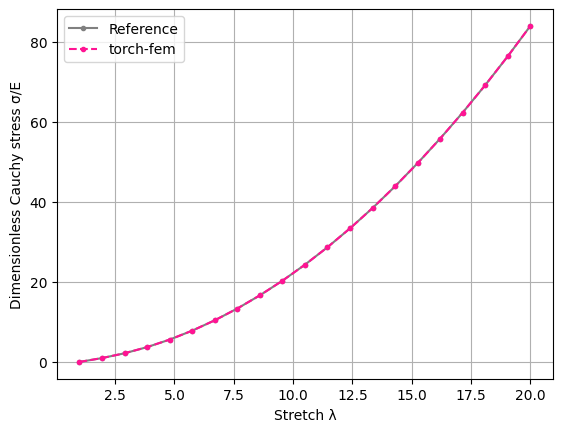

In [6]:
def psi(F):
    """Neo-Hookean strain energy density function."""
    # Compute the right Cauchy-Green deformation tensor
    C = F.transpose(-1, -2) @ F
    # Stable computation of the logarithm of the determinant
    logJ = 0.5 * torch.logdet(C)
    return mu / 2 * (torch.trace(C) - 3.0) - mu * logJ + lbd / 2 * logJ**2


# Create model
material = Hyperelastic3D(psi)

box = Solid(nodes, elements, material)
box.constraints = constraints
box.displacements = displacements

# Solve
_, _, σn, _, _ = box.solve(increments=increments, return_intermediate=True, nlgeom=True)


with torch.no_grad():
    plt.plot(λ, σn_ref / E, ".-", color="gray", label="Reference")
    plt.plot(
        λ,
        σn[..., 0, 0].mean(dim=1) / E,
        ".--",
        color="deeppink",
        label="torch-fem",
    )
    plt.xlabel("Stretch λ")
    plt.ylabel("Dimensionless Cauchy stress σ/E")
    plt.grid()
    plt.legend()
    plt.show()

## Comparison

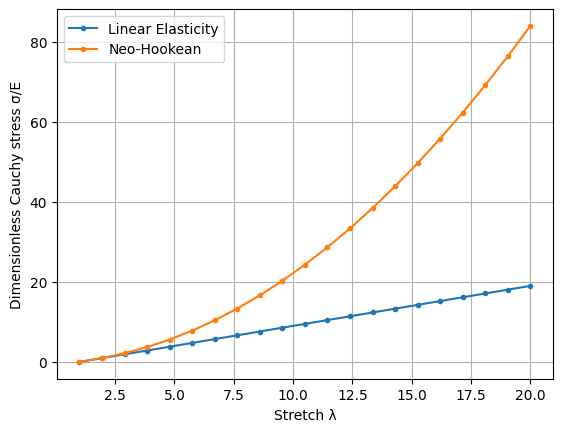

In [7]:
with torch.no_grad():
    plt.plot(λ, σl[..., 0, 0].mean(dim=1) / E, ".-", label="Linear Elasticity")
    plt.plot(λ, σn[..., 0, 0].mean(dim=1) / E, ".-", label="Neo-Hookean")
    plt.xlabel("Stretch λ")
    plt.ylabel("Dimensionless Cauchy stress σ/E")
    plt.grid()
    plt.legend()
    plt.show()